In [46]:
import pandas as pd
from astroquery.mast import Observations, Catalogs
import matplotlib.pyplot as plt

# import numpy as np
# import glob
# from astropy.io import ascii
# from astropy.table import Table, join, vstack
# from astropy.io import fits
# import lightkurve as lk
# from operator import itemgetter

In [88]:
# unique item finder

def uniquefinder(mylist):
    seen = {}
    dupes = []
    uniq_tics = []
    for x in mylist:
        if x not in seen:
            seen[x] = 1
            uniq_tics.append(x)
        else:
            if seen[x] == 1:
                dupes.append(x)
            seen[x] += 1
    uniques = len(uniq_tics)
    print('there are {} unique tics. Use the first output dictionary'.format(uniques), \
          'to see number of occurances for duplicates')
    return seen, uniq_tics

## Notebook Goals:
- 1) gets/opens sector tic id lists
- 2) downloads tic catalog based on tic ids (temp cuts, get ra/dec)
- 3) uses ra/dec for mast query to get data urls
- 4) creates shell script to download raw lc files 

- 5) merges/matches pipeline stats into tic catalog

# ONE

In [24]:
## open tic id lists per sector
# lists downloaded from https://tess.mit.edu under top menu item "Observations"-->"Target Lists" OR Sectors"-->"Sector #"--->scroll down to list dl .txt or .csv
# NOTE: weird error with ^^ those files, need to 1)add space after "colname, " AND 2)use 'skiprows' below to get read by pandas

sec14_file = pd.read_csv('data/SECTORS/all_targets_S014_v1.csv',skiprows=5) #overlaps kepler
sec15_file = pd.read_csv('data/SECTORS/all_targets_S015_v1.csv',skiprows=5) #overlaps kepler
# sec14_file 
sec15_file

,TICID,Camera,CCD,Tmag,RA,Dec
0,10747057,4,1,8.93,212.3885,53.8912
1,10757120,1,2,13.57,303.6666,41.8261
2,10759029,1,2,13.87,303.7226,41.3383
3,10849428,1,2,12.99,303.7143,39.9199
4,10856385,1,2,14.00,303.6650,38.8385
...,...,...,...,...,...,...
19995,2005005557,1,4,9.78,325.0506,37.0564
19996,2005271830,1,1,8.26,326.6064,39.8506
19997,2006808209,1,4,16.85,320.6398,36.1249
19998,2017203852,2,4,17.13,321.4574,52.5245


In [28]:
#pull tic ids
ticid_sec15 = sec15_file['TICID'].to_numpy() #full sample
ticid_sec14 = sec14_file['TICID'].to_numpy() #full sample


len(ticid_sec15)

20000

 # TWO

In [74]:
## get tic catalog to do teff cut prior to lc dl
catalog_data_sec15 = Catalogs.query_criteria(catalog='Tic',ID=ticid_sec15)

# catalog_data_sec15['ID']=catalog_data_sec15['ID'].astype(int)

#rename TIC ID column to match target name from Mast file for matching ease later
catalog_data_sec15.rename_column('ID', 'target_name')
catalog_data_sec15#[0:5] # astropy.table


target_name,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,APASS,KIC,objType,typeSrc,ra,dec,POSflag,pmRA,e_pmRA,pmDEC,e_pmDEC,PMflag,plx,e_plx,PARflag,gallong,gallat,eclong,eclat,Bmag,e_Bmag,Vmag,e_Vmag,umag,e_umag,gmag,e_gmag,rmag,e_rmag,imag,e_imag,zmag,e_zmag,Jmag,e_Jmag,Hmag,e_Hmag,Kmag,e_Kmag,TWOMflag,prox,w1mag,e_w1mag,w2mag,e_w2mag,w3mag,e_w3mag,w4mag,e_w4mag,GAIAmag,e_GAIAmag,Tmag,e_Tmag,TESSflag,SPFlag,Teff,e_Teff,logg,e_logg,MH,e_MH,rad,e_rad,mass,e_mass,rho,e_rho,lumclass,lum,e_lum,d,e_d,ebv,e_ebv,numcont,contratio,disposition,duplicate_id,priority,eneg_EBV,epos_EBV,EBVflag,eneg_Mass,epos_Mass,eneg_Rad,epos_Rad,eneg_rho,epos_rho,eneg_logg,epos_logg,eneg_lum,epos_lum,eneg_dist,epos_dist,distflag,eneg_Teff,epos_Teff,TeffFlag,gaiabp,e_gaiabp,gaiarp,e_gaiarp,gaiaqflag,starchareFlag,VmagFlag,BmagFlag,splists,e_RA,e_Dec,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID
str10,str8,int64,str12,str10,str16,str19,str19,str19,str8,int64,str4,str11,float64,float64,str11,float64,float64,float64,float64,str6,float64,float64,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,str5,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64,float64,float64,float64,int64,float64,str9,str9,float64,float64,float64,str9,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str6,float64,float64,str6,float64,float64,float64,float64,int64,str1,str11,str8,str15,float64,float64,float64,float64,float64,float64,int64,int64,str9
142873270,20190415,--,4393-01096-1,795-021315,11450342+6849003,--,J114503.34+684900.2,1061226808990533504,59588043,--,STAR,tmgaia2,176.264207904196,68.8167487435556,tmgaia2,-43.3853,0.0454748,-5.6649,0.0388793,gaia2,9.3324,0.0290067,gaia2,131.663886115959,47.1701590323277,132.573220401302,57.7923594522294,10.76,0.059,10.04,0.004,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,8.811,0.026,8.448,0.018,8.387,0.016,AAA-112-111-000-0-0,nan,8.338,0.023,8.365,0.019,8.317,0.021,8.185,0.194,9.90129,0.000676,9.45175,0.0062,rered,gaia2,5684.0,127.763,4.43729,0.0801764,nan,nan,1.00639,0.0496935,1.011,0.134572,0.991865,0.219955,DWARF,0.9524524,0.02527985,106.823,0.3335,0.00701263,0.00248831,42,0.009988496,--,--,0.00400481233,0.0017587,0.00321792,panstarrs,0.134539,0.134605,0.0531487,0.0462382,0.212842,0.227068,0.0929447,0.0674081,0.030323,0.0202367,0.332,0.335,bj2018,123.224,132.303,dered,10.251,0.001752,9.39233,0.001695,1,--,tycho2v3,tycho2b3,--,0.854663049313676,0.603012151641203,176.263690962788,68.8167243537995,0.0233903908550558,0.0214886620623852,1,0,144071591
142873206,20190415,--,4393-00736-1,796-021197,11445726+6905036,--,J114457.25+690503.6,1061280959939235968,59588029,--,STAR,tmgaia2,176.238554534287,69.084342411457,tmgaia2,5.55464,0.0467625,-2.30136,0.0439922,gaia2,0.639475,0.0282675,gaia2,131.529836516879,46.9184701746701,132.18601129608,57.9635363714721,11.617,0.077,9.998,0.018,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,7.211,0.019,6.471,0.016,6.242,0.016,AAA-111-111-000-0-0,nan,6.183,0.103,6.267,0.026,6.195,0.015,6.098,0.045,9.43763,0.000316,8.568,0.0064,rered,gaia2,3980.0,122.0,nan,nan,nan,nan,47.058,nan,nan,nan,nan,nan,GIANT,nan,nan,1490.91,63.085,0.0243044,0.00443058,--,nan,--,--,nan,0.00346034,0.00540082,panstarrs,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,60.48,65.69,bj2018,nan,nan,dered,10.3627,0.00227,8.52183,0.00152,1,--,tycho2v3,tycho2b3,--,0.880283863266834,0.682246536666088,176.238621526616,69.0843325028366,0.0244207012364221,0.0223881615159014,0,0,144071529
142871763,20190415,--,4393-00178-1,788-022244,11444652+6730309,--,J114446.46+673031.1,1057897075465469952,59588011,--,STAR,tmgaia2,176.193860428114,67.5085322116919,tmgaia2,-29.9386,1.2475,36.789

In [62]:
# do temp cut

tempcut_sec15 = catalog_data_sec15[catalog_data_sec15['Teff']<6500]
tics_sec15 = list(tempcut_sec15['target_name']) #strings #cool stars only

print('Sector-15 full sample size:',len(catalog_data_sec15))
print('Sector-15 after temp cut size:',len(tempcut_sec15))
# catalog_data_sec15.colnames
# len(tics_sec15),min(tempcut_sec15['Teff'])

/Users/helenfellow/opt/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


Sector-15 full sample size: 20000
Sector-15 after temp cut size: 16367


# THREE

RA (min/max): 165.406361318066 334.524244023761
DEC (min/max): 19.9359797307246 80.8258934762107


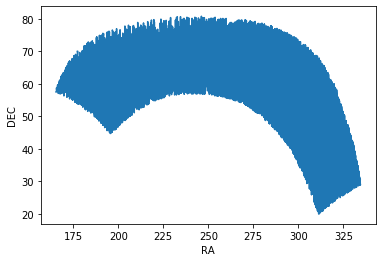

In [49]:
#determine RA/DEC bounds for mast url query

ra_sec15 = tempcut_sec15['ra']
dec_sec15 = tempcut_sec15['dec']
print('RA (min/max):',min(ra_sec15),max(ra_sec15))
print('DEC (min/max):',min(dec_sec15),max(dec_sec15))

plt.plot(ra_sec15,dec_sec15);plt.xlabel('RA');plt.ylabel('DEC');

In [55]:
## open mast query file to match ticids then get lc url
# got from mast at https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html
# then top menu 'Advanced Search' and query ra/dec bounds


# supposed to be full Northern Hemisphere 
northern_hem_mast_file = pd.read_csv('data/SECTORS/MAST_2020-08-06T2317.csv',skiprows=4) #dec=(19-81),filters=TESS
print('northern hemp total number of files:',len(northern_hem_mast_file))
northern_hem_mast_file[0:5]

northern hemp total number of files: 249883


,dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,...,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
0,timeseries,3,TESS,tess2019331140908-s0019-0000000310341755-0164-s,310341755,82.994473,51.395750,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 82.99447268 51.39575048 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000696530,17003836598
1,timeseries,3,TESS,tess2019331140908-s0019-0000000243353559-0164-s,243353559,290.355795,57.766808,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 290.35579495 57.76680784 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000696546,17003836630
2,timeseries,3,TESS,tess2019331140908-s0019-0000000127968322-0164-s,127968322,81.726321,35.457272,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 81.72632138 35.45727236 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000696698,17003836934
3,timeseries,3,TESS,tess2019331140908-s0019-0000000310973373-0164-s,310973373,85.024499,49.066400,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 85.02449863 49.06640044 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000698786,17003843664
4,timeseries,3,TESS,tess2019331140908-s0019-0000000309866670-0164-s,309866670,81.805490,53.565967,58815.575983,58840.648195,120,...,SPOC,CIRCLE ICRS 81.80548963 53.56596720 0.00138889,NaN,mast:TESS/product/tess2019331140908-s0019-0000...,PUBLIC,False,NaN,science,17000699100,17003847924


In [94]:
## match mast file with tempcut tic ids

mastid = northern_hem_mast_file['target_name'].to_numpy()
# convert types for merge
tempcut_sec15_df = tempcut_sec15.to_pandas() #make table a df for joining
northern_hem_mast_file['target_name'] = northern_hem_mast_file['target_name'].astype(str) #b/c tempcut tic catalog is string IDs (and cant convert that to int for some reason?(N/A)??)


# merge 
mast_ticcat_merge = pd.merge(tempcut_sec15_df, northern_hem_mast_file, how='left', on='target_name') #how to only keep mytics
print('before merge:',len(tempcut_sec15_df),' after merge:',len(mast_ticcat_merge),'targets')
# print('--these are different b/c includes cvz where camera4 targets are observed in multiple sectors-- \n'
#       'i.e.-this is data from more than one sector ')

# test for how many unique tics merged
dupes, uniques = uniquefinder(mast_ticcat_merge['target_name'].to_numpy())
print('These two better match:', len(tempcut_sec15_df),len(uniques))#'otherwise some targets have no lc datafiles')

before merge: 16367  after merge: 103418 targets
there are 16367 unique tics. Use the first output dictionary to see number of occurances for duplicates
These two better match: 16367 16367


# FOUR

In [95]:
## create shell text strings from mast url's

curlscript = []
for i in range(len(mast_ticcat_merge)):
    firststr = 'curl -C - -L -o '
    middlestr = str(mast_ticcat_merge['obs_id'][i]) +'_lc.fits '
    webaddy = "https://mast.stsci.edu/api/v0.1/Download/file/?uri=" 
    laststr = webaddy +str(mast_ticcat_merge['dataURL'][i])
    script = firststr + middlestr + laststr 
    #print(script)
    curlscript.append(script)
curlscript=np.array(curlscript)
curlscript.shape



(103418,)

In [97]:
## create shell script (remove outter ''' ''' if need to rerun)

''' 


with open ('data/SECTORS/Sector_15/dl_sec15.sh', 'w') as rsh:
    for count,script in enumerate(curlscript):
        rsh.write('''\
#! /bin/bash
{}
'''.format(script))



'''

# ----------------------TESTS--------------------------

In [39]:
type(tempcut_sec15),type(catalog_data_sec15)

(astropy.table.table.Table, astropy.table.table.Table)

In [57]:
left = pd.DataFrame({'key1': ['K0', 'K0', 'K1', 'K2'],
                    'key2': ['K0', 'K1', 'K0', 'K1'],
                     'A': ['A0', 'A1', 'A2', 'A3'],
                      'B': ['B0', 'B1', 'B2', 'B3']})
 

right = pd.DataFrame({'key1': ['K0', 'K1', 'K1', 'K2'],
                       'key2': ['K0', 'K0', 'K0', 'K0'],
                       'C': ['C0', 'C1', 'C2', 'C3'],
                     'D': ['D0', 'D1', 'D2', 'D3']})
  

result = pd.merge(left, right, on=['key1', 'key2'])


In [80]:
northern_hem_mast_file['target_name'] = northern_hem_mast_file['target_name'].astype(str)


In [81]:
northern_hem_mast_file['target_name'].dtypes

dtype('O')

In [75]:
# catalog_data_sec15['target_name']=catalog_data_sec15['target_name'].astype(int)
# catalog_data_sec15

In [78]:
# for i in catalog_data_sec15['target_name']:
# #     print(i[0])
#     if i[0] =='1':
#         print(i)

142873270
142873206
142871763
138590320
138589321
138589319
138589133
138588969
138588540
138588256
138581189
138581098
138580976
138580742
138580326
138579976
137802100
137799449
137778038
137777511
137777387
142871245
137771580
137771290
137733937
137733927
137733738
141146699
141146618
141146598
141146362
137750487
100013827
100013706
142933327
142933200
142932867
138649216
138635005
138634934
138634899
138634813
138634721
138634718
138634714
137830928
137830829
137830034
11895653
11893760
142905711
142905656
142905605
142905376
138634446
138633853
138633474
138632911
137829826
137810939
137810850
137810490
137810062
137809960
137809671
137809550
137809189
142904393
142903658
142903619
142903121
138619668
137808982
137808926
137804556
137804501
142963060
137804449
137804387
137804318
137803591
137803552
137803409
137802864
142878895
142877228
142876824
138618727
138618648
138618451
138618351
138592011
138591588
138591451
138591201
138590902
138590414
138590375
138589695
137803226
13

159343514
160421169
160422821
161732281
160394213
161745227
161745243
161745470
1102493238
1102630962
159343218
159343581
160421752
160422453
198555714
160422712
160422910
160423277
198555943
198555959
160423655
198556820
161685732
198557182
198557730
159345168
165791151
160424205
160424753
160424912
160438146
161686976
161687311
159333170
160396180
160396515
198312133
198312211
160409532
1102503442
160408950
160409183
160409246
198312776
198312917
159347592
198313291
198313473
159347870
198313491
160471399
160409377
160409489
160410138
160471611
160471808
160410397
160410434
160410561
160472086
161726611
161727024
161727053
198536840
198536913
198536950
198537349
198537575
198315173
198537750
198537783
160410186
198314169
198314276
198315969
198316044
198316180
160419128
160419363
159400005
160488131
198556895
1102642384
1102395903
161722047
161724619
160409816
1102452862
160472749
160488046
160488070
160488140
198554945
1102636440
161729711
161729947
198553139
198555114
198555309
198

158490831
158491283
158323231
159047957
159048032
1718070519
158393140
158785938
158412633
158412763
158414629
158625863
158488549
158489285
158325335
158491837
158728473
158728853
158731429
158731725
158417251
158787519
158983365
158983460
158985758
159054117
159176945
158838104
159225871
159226501
158835783
158839292
159227007
159299483
159301268
158839677
158843061
158983335
158936104
158988347
1717994248
159049238
159050047
159050655
159051209
1717455451
1718205142
159047480
159055335
159098206
159107668
159171617
159172010
159176672
159441469
159449703
159515804
159442648
159305212
159386347
159387915
159392323
159392907
159513058
159107250
159390161
159443078
159169838
159441328
159645336
159650494
159650513
1884091865
159299691
159302302
1884497349
1884438653
159577231
159580383
159583441
1883668125
159577432
159578658
159580386
159644707
159644070
159644241
159720778
159721038
159723646
1884231689
159719243
159302845
159719806
159719826
159723531
159724815
159725384
159726150
1

163609125
160041500
160046215
160051304
160051533
15181144
15199714
15199985
15207484
160104585
13576069
160165974
13657340
160169835
160170507
13658517
160253433
15298476
15298798
160251539
160310038
160313892
15302757
15303727
160318989
160320467
160380517
160380785
160382708
160383839
13716192
160387217
13725513
160387910
160389000
160389159
160389513
160428500
160431888
160509330
160509838
15420082
15420687
15420746
15420789
15422269
15422557
160432299
160433295
160506107
160512940
160513407
160513731
160513851
160515126
160516175
160516648
160588238
117290725
117390796
117451215
138532756
1974667188
13470446
13473357
13473824
117538202
117540241
117540364
138618021
138677640
160725141
160727006
160727655
160729601
160732875
160735199
160737220
160801087
160802102
13573545
160806582
160807230
15039353
15039357
160804898
160854782
160102491
160103179
160177115
160177304
160259265
160312442
160862106
160862807
160939301
160946910
160948223
160981618
160985229
15452873
15456583
154602